# Exploratory Data Analysis

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
from collections import Counter
from statistics import mean

import warnings
warnings.filterwarnings('ignore')

In [3]:
db_path = "lottery.db"

In [4]:
def fromDBtoDF(query):
    con = sqlite3.connect(db_path)
    cur = con.cursor()
    cur.execute(query)
    names = list(map(lambda x: x[0], cur.description))
    info = cur.fetchall()
    con.commit()
    con.close()
    return pd.DataFrame(info, columns = names)

In [5]:
draws_df = fromDBtoDF("""SELECT * FROM `DRAWS`""")

In [6]:
draws_df.head(3)

,turn,num_1,num_2,num_3,num_4,num_5,num_6,num_bonus
0,1,10,23,29,33,37,40,16
1,2,9,13,21,25,32,42,2
2,3,11,16,19,21,27,31,30


In [7]:
def recentDrawInDB(db_path):
    con = sqlite3.connect(db_path)
    cur = con.cursor()
    cur.execute("SELECT MAX(turn) FROM DRAWS")
    info = cur.fetchall()
    con.commit()
    con.close()
    return int(info[0][0])

In [8]:
def number_frequencies(firstDraw=1, lastDraw=recentDrawInDB(db_path)):
    nums = []
    for c in draws_df.columns[1:-1]:
        nums = nums + list(draws_df[(draws_df['turn'] >= firstDraw) & (draws_df['turn'] <= lastDraw)][c])
    nums_counter = Counter(nums)
    min_freq_key, max_freq_key = min(nums_counter, key=lambda x:nums_counter[x]), max(nums_counter, key=lambda x:nums_counter[x])
    min_freq, max_freq = nums_counter[min_freq_key], nums_counter[max_freq_key]
    freq_mean = mean(list(map(lambda x : nums_counter[x], nums_counter)))
    plt.rcParams['figure.figsize'] = [15, 8]
    fig = plt.hist(nums, bins=45, edgecolor='black', linewidth=1.2)

    plt.plot([2., 44], [freq_mean, freq_mean], 'k--')
    plt.ylabel('Count', fontsize = 12)
    plt.xlabel('Number', fontsize = 12)
    plt.xlim(1, 45)
    plt.ylim(min_freq - 1, max_freq + 1)
    plt.title('Number Frequency')
    plt.show()
    return nums_counter

In [9]:
mostRecentDraw = recentDrawInDB(db_path)
firstDraw = 1

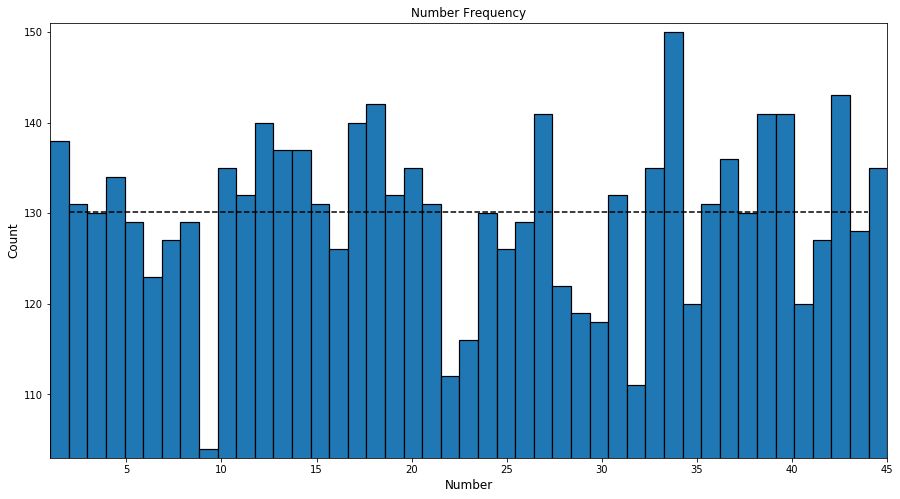

In [10]:
nums_counter = number_frequencies(firstDraw, mostRecentDraw)

In [12]:
print(" "*20 + f"From Draw #{firstDraw} to Draw #{mostRecentDraw}")
print("10 Most Common Numbers:" + " "*20 + "10 Least Common Numbers :")
for (n, freq), (n2, freq2) in zip(nums_counter.most_common(45)[:10], nums_counter.most_common(45)[:-11:-1]):
    print(f"#{n : >2}: {freq : >4} Times", end=" "* 28)
    print(f"#{n2 : >2}: {freq2 : >4} Times")

                    From Draw #1 to Draw #976
10 Most Common Numbers:                    10 Least Common Numbers :
#34:  150 Times                            # 9:  104 Times
#43:  143 Times                            #32:  111 Times
#18:  142 Times                            #22:  112 Times
#27:  141 Times                            #23:  116 Times
#39:  141 Times                            #30:  118 Times
#40:  141 Times                            #29:  119 Times
#17:  140 Times                            #41:  120 Times
#12:  140 Times                            #35:  120 Times
# 1:  138 Times                            #28:  122 Times
#14:  137 Times                            # 6:  123 Times


In [104]:
draws_summary = draws_df.describe().iloc[1:, 1:]
draw_mins = draws_summary.loc['min']
draw_maxs = draws_summary.loc['max']
draws_summary

,num_1,num_2,num_3,num_4,num_5,num_6,num_bonus
mean,6.604508,13.034836,19.955943,26.266393,32.878074,39.507172,22.376025
std,5.277270,6.839164,7.476123,7.626723,6.857561,5.289171,13.246422
min,1.000000,2.000000,3.000000,5.000000,9.000000,19.000000,1.000000
25%,2.000000,8.000000,14.000000,21.000000,28.000000,37.000000,11.000000
50%,5.000000,12.000000,19.000000,27.000000,34.000000,41.000000,23.000000
75%,10.000000,17.250000,25.000000,32.000000,38.000000,44.000000,34.000000
max,35.000000,37.000000,40.000000,43.000000,44.000000,45.000000,45.000000


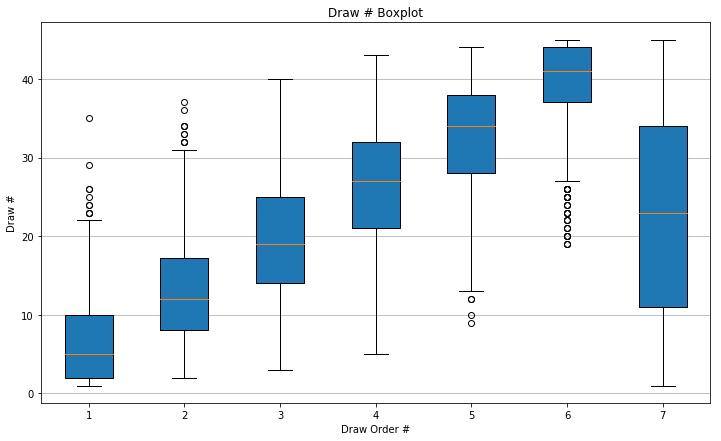

In [103]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(draws_df.iloc[:, 1:].T, vert=True,patch_artist=True)
ax.set_title('Draw # Boxplot')
ax.set_xlabel('Draw Order #')
ax.set_ylabel('Draw #')
ax.yaxis.grid(True)
plt.show()

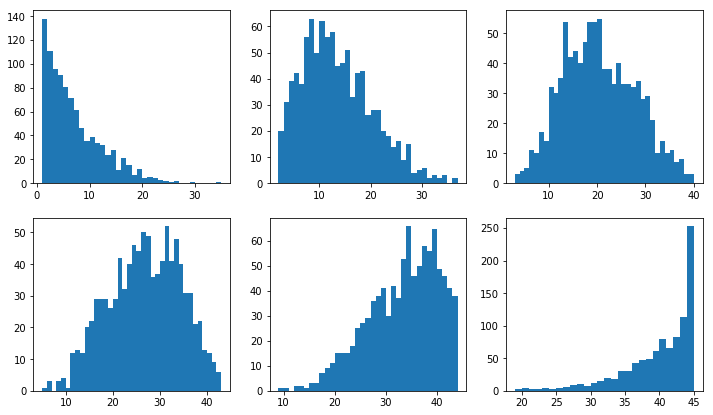

In [106]:
fig, ax = plt.subplots(figsize=(12, 7), nrows=2, ncols=3)
for i in range(2):
    for j in range(3):
        seq = 3 * i + j
        ax[i][j].hist(draws_df['num_' + str(seq + 1)], bins = int(draw_maxs[seq] - draw_mins[seq]))
        #ax[i][j].add_line()
plt.show()

In [13]:
query_winner_select = """SELECT * FROM `WINNERS`""" # turn, win1, 2, 3, 4, 5
query_prize_select = """SELECT * FROM `PRIZES`""" # turn, prize1, 2, 3, 4, 5
query_date_select = """SELECT * FROM `DATES`""" # turn, year, month, day
query_store_select = """SELECT * FROM `STORES`""" # idx, turn, name, auto, firstPrize, address